<a href="https://colab.research.google.com/github/salvaderron/Artificial-Neural-Network_and_Deep-Learning/blob/main/ANN_%26_DL_Lab_8_(Vision_Transformer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# 1. Configuration
num_classes = 10
input_shape = (32, 32, 3)  # CIFAR-10 images
patch_size = 4
num_patches = (input_shape[0] // patch_size) ** 2
projection_dim = 64
transformer_layers = 4
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]

# 2. Load and preprocess a small subset of CIFAR-10
(x_train, y_train), _ = keras.datasets.cifar10.load_data()
x_train, y_train = x_train[:2000], y_train[:2000]  # use 2k samples for speed
x_train = x_train.astype("float32") / 255.0
y_train = y_train.flatten()

# 3. Define Patches layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

# 4. Define PatchEncoder layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.pos_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        x = self.projection(patch)
        return x + self.pos_embedding(positions)

# 5. Build the ViT model
inputs = layers.Input(shape=input_shape)
patches = Patches(patch_size)(inputs)
encoded = PatchEncoder(num_patches, projection_dim)(patches)

for _ in range(transformer_layers):
    # Layer Norm -> MHA -> Skip
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded)
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    x2 = layers.Add()([attn_output, encoded])
    # Layer Norm -> MLP -> Skip
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    mlp_output = layers.Dense(transformer_units[0], activation='relu')(x3)
    mlp_output = layers.Dense(transformer_units[1])(mlp_output)
    encoded = layers.Add()([mlp_output, x2])

# Classification head
representation = layers.LayerNormalization(epsilon=1e-6)(encoded)
representation = layers.Flatten()(representation)
representation = layers.Dense(128, activation='relu')(representation)
outputs = layers.Dense(num_classes, activation='softmax')(representation)

model = keras.Model(inputs=inputs, outputs=outputs)

# 6. Compile and train (1 epoch)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

print("Training finished!")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 495ms/step - accuracy: 0.1014 - loss: 3.6765
Training finished!


157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.0969 - loss: 2.3026
Test Loss: 2.3025, Test Accuracy: 0.0993
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.0983    0.9710    0.1785      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.0000    0.0000    0.0000      1000
           5     0.0000    0.0000    0.0000      1000
           6     0.0000    0.0000    0.0000      1000
           7     0.1880    0.0220    0.0394      1000
           8     0.0000    0.0000    0.0000      1000
           9     0.0000    0.0000    0.0000      1000

    accuracy                         0.0993     10000
   macro avg     0.0286    0.0993    0.0218     10000
weighted avg     0.0286    0.0993    0.0218     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


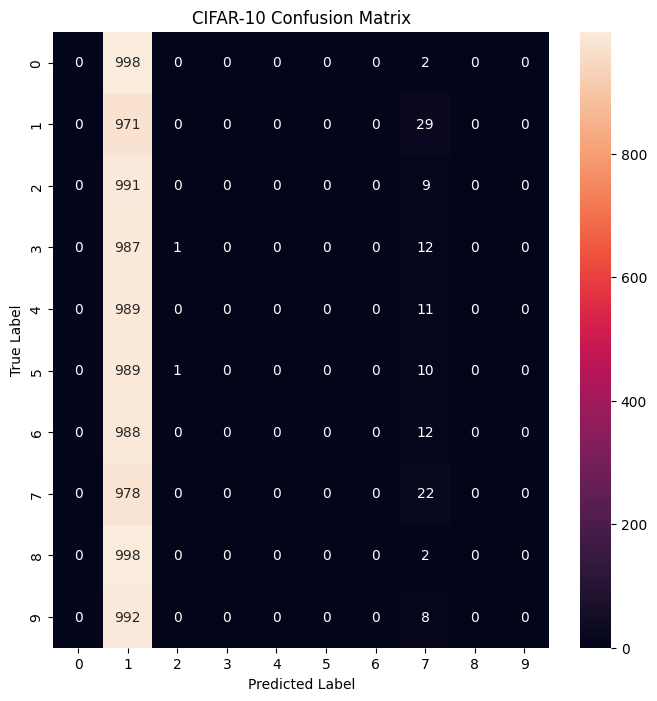

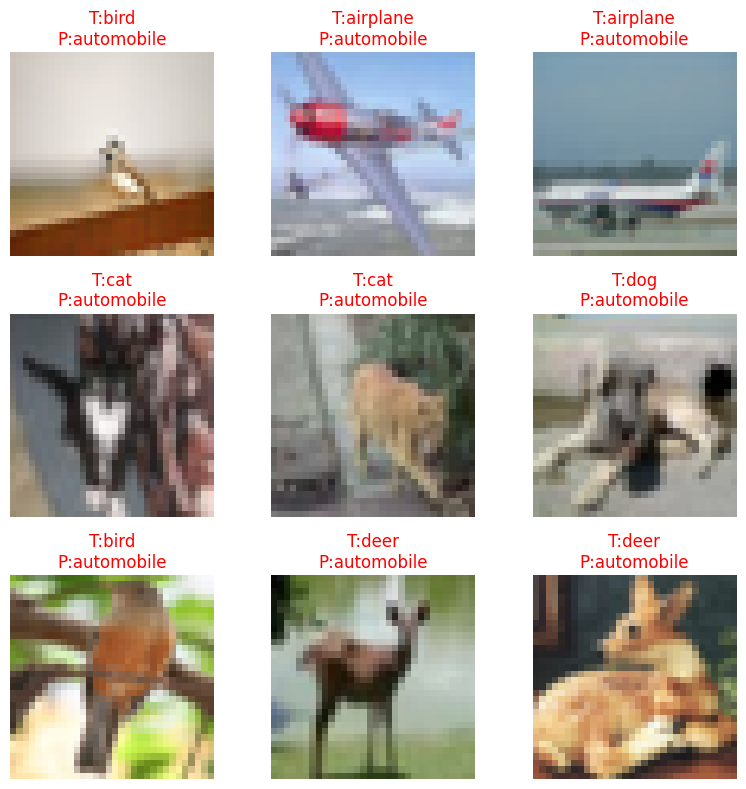

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns  # for nicer matrix display, optional

# --- 1. Prepare test data ---
(_, _), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_test = x_test.astype("float32") / 255.0
y_test = y_test.flatten()

# If you saved your training history:
# history = model.history  # only if you captured it via `history = model.fit(...)`

# --- 2. Evaluate on test set ---
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=64)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# --- 3. Get predictions & classification report ---
y_pred_probs = model.predict(x_test, batch_size=64)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# --- 4. Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CIFAR-10 Confusion Matrix')
plt.show()

# --- 5. Sample Predictions (optional) ---
class_names = [
    'airplane','automobile','bird','cat','deer',
    'dog','frog','horse','ship','truck'
]
num_examples = 9
idxs = np.random.choice(len(x_test), num_examples, replace=False)
plt.figure(figsize=(8,8))
for i, idx in enumerate(idxs):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_test[idx])
    true_lbl = class_names[y_test[idx]]
    pred_lbl = class_names[y_pred[idx]]
    color = 'green' if y_pred[idx] == y_test[idx] else 'red'
    ax.set_title(f"T:{true_lbl}\nP:{pred_lbl}", color=color)
    ax.axis('off')
plt.tight_layout()
plt.show()


***Analysis of the Output
Consistent Misclassification to "automobile":

Every image in this sample has been predicted as "automobile", regardless of its actual class (which includes "cat", "dog", "bird", "airplane").

This is likely a bias in the model's predictions, often due to:

Underfitting or very limited training (e.g., only 1 epoch).

Not enough diverse data (only 2000 samples were used).

Class imbalance in the training subset.

Poor model capacity or architectural tuning.

What It Suggests:

The model hasn't learned to distinguish between classes properly.

It may be defaulting to predicting "automobile" because that class was overrepresented or because it minimized loss best during poor training. ***